# Quantum Neural Network Classifiers: A Tutorial

## 项目介绍

该论文主要讨论了在量子神经网络的不同编码结构和编码策略在解决监督学习任务时的区别。文章对幅度编码和块编码在量子神经网络处理二分类问题时的表现进行了对比。作为测试基准，Fashion MNIST、MNIST、对称性保护拓扑态等数据集用来作为识别训练任务。本次论文复现要求：研究并理解文章内容,利用MindQuantum实现对Table 2中 对Fashion Mnist及MNIST的分类任务的结果。原文链接：https://scipost.org/SciPostPhysLectNotes.61

## 复现过程

### 数据预处理
原文章主要讨论的是利用量子神经网络在二分类问题中的应用，具体任务设置为对Fashion MNIST中对靴子和T恤图片进行分类，对MNIST中的手写体“0”和“1”进行分类。初始数据为.mat格式，想要用于训练我们需要对其进行预处理

In [1]:
import h5py 
import scipy.io
import numpy as np

train_num = 1000
test_num = 200

dataset = h5py.File('./Dataset/FashionMNIST_1_2_wk.mat')
train_data = np.transpose(dataset['x_train'])
train_label = np.transpose(dataset['y_train'])
test_data = np.transpose(dataset['x_test'])
test_label = np.transpose(dataset['y_test'])

train_pixels = np.array(train_data[:,:train_num].tolist())[:,:,0].transpose() # [:,:,0]取实部
test_pixels = np.array(test_data[:,:test_num].tolist())[:,:,0].transpose()
train_index = train_label[:train_num,0].astype(int) # 0-> 靴子 1->T恤
test_index = test_label[:test_num,0].astype(int)

/tmp/ipykernel_74363/3271068640.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  dataset = h5py.File('./Dataset/FashionMNIST_1_2_wk.mat')


train_pixels和test_pixels分别为训练和测试用的像素数据，train_index和test_index为训练和测试标签。训练样本和测试样本大小分别为1000和200.

可以通过matplotlib.pyplot对样本进行可视化

前2个训练集标签为 [0 1]


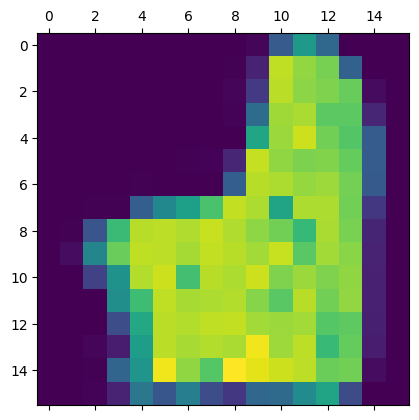

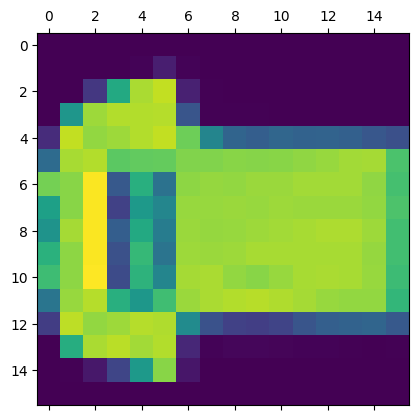

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.matshow(np.reshape(train_pixels[0,:],[16,16]))
plt.matshow(np.reshape(train_pixels[1,:],[16,16]))
print(f'前2个训练集标签为 {train_index[:2]}')

目前训练数据为像素数据，不能作为输入态直接用于量子线路，需要用幅度编码将像素数据转换为线路参量数据.

mindquantum提供的mindquantum.algorithm.library.amplitude_encoder编码器可以方便地实现这一过程。

In [3]:
from mindquantum.algorithm.library import amplitude_encoder
def amplitude_param(pixels):
    param_rd = []
    _, parameterResolver = amplitude_encoder(pixels, 8)   
    for _, param in parameterResolver.items():
        param_rd.append(param)
    param_rd = np.array(param_rd)
    return param_rd

# 将幅度转为编码线路参数，幅度shape(256,)，参数shape(255,)
train_param = np.array([amplitude_param(i) for i in train_pixels ])
test_param = np.array([amplitude_param(i) for i in test_pixels ])

/home/pp/.local/lib/python3.8/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Disable mqvector gpu backend due to: Malloc GPU memory failed: cudaErrorInsufficientDriver, CUDA driver version is insufficient for CUDA runtime version
  from .available_simulator import SUPPORTED_SIMULATOR


将参数数据和标签封装ms.dataset.NumpySlicesDataset用于训练，数据预处理环节完成。

该过程在main.py中Main()类的data_preporcess方法实现。

In [4]:
import mindspore as ms
BATCH_SIZE = 100
train_loader = ms.dataset.NumpySlicesDataset(
    {'features': train_param, 'labels': train_index}, shuffle=True).batch(BATCH_SIZE) 
test_loader = ms.dataset.NumpySlicesDataset(
    {'features': test_param, 'labels': test_index}).batch(BATCH_SIZE)  

### 量子线路搭建

要实现数据分类需要定义含参ansatz线路。本次复现论文中提供三种ansatz，每个ansatz中包括参数层和纠缠层。

一层参数层和一层纠缠层构成一个复合层(block)，复合层数越多说明ansatz线路越深。

纠缠层有三种Ent1、Ent2、Ent3，所以三种ansatz对应的是三种纠缠层与参数层的组合。

In [5]:
from mindquantum.core.circuit import Circuit
import mindquantum.core.gates as Gate

def Classifying_circuit(qubit_num, block_num, Ent_circ):
    num = qubit_num
    depth = block_num
    circ = Circuit()
    for i in range(depth):
        circ = Para_circuit(circ, num)
        if Ent_circ == 'Ent1':
            circ = Ent1_circuit(circ, num)
        elif Ent_circ == 'Ent2':
            circ = Ent2_circuit(circ, num)
        elif Ent_circ == 'Ent3':
            circ = Ent3_circuit(circ, num)
    return circ

def Ent1_circuit(circuit,qubit_num):
    for i in range(0,qubit_num-1,2):
        circuit += Gate.Z.on(i+1,i)
    for i in range(1,qubit_num-2,2):
        circuit += Gate.Z.on(i+1,i)
    return circuit

def Ent2_circuit(circuit,qubit_num):
    for i in range(0,qubit_num-1,2):
        circuit += Gate.X.on(i+1,i)
    for i in range(1,qubit_num-2,2):
        circuit += Gate.X.on(i+1,i)
    return circuit

def Ent3_circuit(circuit,qubit_num):
    circuit = Ent2_circuit(circuit,qubit_num)
    circuit = Ent2_circuit(circuit,qubit_num)
    return circuit

def Para_circuit(circuit,qubit_num):
    for i in range(qubit_num):
        circuit += Gate.RX(f'Xtheta{i}').on(i)
        circuit += Gate.RZ(f'Ztheta{i}').on(i)
        circuit += Gate.RX(f'Xtheta2{i}').on(i)
    return circuit

Classifying_circuit(qubit_num, block_num, Ent_circ)可以通过传入比特数、复合层层数、纠缠层名称来定义ansatz

In [6]:
QUBIT_NUM = 8
BLOCK_NUM = 2
Ent = 'Ent1'
ansatz = Classifying_circuit(QUBIT_NUM,BLOCK_NUM,Ent).as_ansatz()

传入初态和比特数定义编码层

In [7]:
encoder = amplitude_encoder([0], QUBIT_NUM)[0].as_encoder()

随后通过Pauli-Z测量最后两个比特用于二分类，设置运行环境和全局种子后线路搭建完成。

In [8]:

from mindquantum.framework import MQLayer
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.simulator import Simulator
import mindspore as ms
WORKER = 4
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(1)
circ = encoder.as_encoder() + ansatz
meas = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [QUBIT_NUM-2, QUBIT_NUM-1]]
sim = Simulator('mqvector', circ.n_qubits)
grad_ops = sim.get_expectation_with_grad(meas, circ, parallel_worker=WORKER)
Qnet = MQLayer(grad_ops)

### 模型训练

In [9]:
class ForwardAndLoss(ms.nn.Cell):
    def __init__(self, backbone, loss_fn):
        super(ForwardAndLoss, self).__init__(auto_prefix=False)
        self.backbone = backbone
        self.loss_fn = loss_fn

    def construct(self, data, label):
        output = self.backbone(data)
        return self.loss_fn(output, label)

    def backbone_network(self):
        return self.backbone


class TrainOneStep(ms.nn.TrainOneStepCell):

    def __init__(self, network, optimizer):
        super(TrainOneStep, self).__init__(network, optimizer)
        self.grad = ms.ops.GradOperation(get_by_list=True)

    def construct(self, data, label):
        weights = self.weights
        loss = self.network(data, label)
        grads = self.grad(self.network, weights)(data, label)
        return loss, self.optimizer(grads)

LR = 0.05
loss = ms.nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean') 
opt = ms.nn.Adam(Qnet.trainable_params(), learning_rate=LR) 
net_with_loss = ForwardAndLoss(Qnet, loss)
train_one_step = TrainOneStep(net_with_loss, opt)

定义评价标准

In [10]:
class EpochLoss(ms.nn.Metric):
    def __init__(self):
        super(EpochLoss, self).__init__()
        self.clear()

    def clear(self):
        self.loss = 0
        self.counter = 0

    def update(self, *loss):
        loss = loss[0].asnumpy()
        self.loss += loss 
        self.counter += 1

    def eval(self):
        return self.loss / self.counter

class EpochAcc(ms.nn.Metric):
    def __init__(self):
        super(EpochAcc, self).__init__()
        self.clear()

    def clear(self):
        self.correct_num = 0
        self.total_num = 0

    def update(self, *inputs):
        y_output = inputs[0].asnumpy()
        y = inputs[1].asnumpy()
        y_pred = np.zeros_like(y)
        for i in range(y_pred.shape[0]):
            yi = y_output[i]
            if yi[0] >= yi[1]:
                y_pred[i] = 0
            else:
                y_pred[i] = 1       
        self.correct_num += np.sum(y == y_pred)
        self.total_num += y.shape[0] 

    def eval(self):
        return self.correct_num / self.total_num
        
acc_epoch = EpochAcc() 
loss_epoch = EpochLoss() 

开始训练

In [12]:
train_loss_epoch = []
train_acc_epoch = []
test_loss_epoch = []
test_acc_epoch = []

STEP_NUM = 30

for epoch in range(STEP_NUM):
    loss_epoch.clear() 
    acc_epoch.clear()

    for data in train_loader: 
        train_one_step(data[0], data[1])   # 执行训练，并更新权重, data[0]参数，data[1]为标签
        loss = net_with_loss(data[0], data[1])  
        loss_epoch.update(loss) 
    train_loss = loss_epoch.eval() 
    train_loss_epoch.append(train_loss)

    # training accuracy
    for data in train_loader:
        logits = Qnet(data[0]) # 向前传播得到预测值
        acc_epoch.update(logits, data[1]) # 计算预测准确率
    train_acc = acc_epoch.eval()
    train_acc_epoch.append(train_acc)

    # testing loss
    for data in test_loader:
        loss = net_with_loss(data[0], data[1])  # 计算损失值
        loss_epoch.update(loss)
    test_loss = loss_epoch.eval()
    test_loss_epoch.append(test_loss)

    # testing accuracy
    for data in test_loader:
        logits = Qnet(data[0])
        acc_epoch.update(logits, data[1])
    test_acc = acc_epoch.eval()
    test_acc_epoch.append(test_acc)

    print(f"epoch: {epoch+1}, training loss: {train_loss}, training acc: {train_acc}, testing loss: {test_loss}, testing acc: {test_acc}")

epoch: 1, training loss: 0.47745896577835084, training acc: 0.959, testing loss: 0.47894489268461865, testing acc: 0.9591666666666666
epoch: 2, training loss: 0.4774593234062195, training acc: 0.959, testing loss: 0.47894519567489624, testing acc: 0.9591666666666666
epoch: 3, training loss: 0.4774597227573395, training acc: 0.959, testing loss: 0.4789454862475395, testing acc: 0.9591666666666666
epoch: 4, training loss: 0.4774601548910141, training acc: 0.959, testing loss: 0.4789458438754082, testing acc: 0.9591666666666666
epoch: 5, training loss: 0.47746056914329527, training acc: 0.959, testing loss: 0.47894613196452457, testing acc: 0.9591666666666666
epoch: 6, training loss: 0.4774609476327896, training acc: 0.959, testing loss: 0.47894638031721115, testing acc: 0.9591666666666666
epoch: 7, training loss: 0.47746134996414186, training acc: 0.959, testing loss: 0.47894666095574695, testing acc: 0.9591666666666666
epoch: 8, training loss: 0.4774617850780487, training acc: 0.959, te

## 项目总结

原文中所给出的ansatz线路对FashionMNIST数据集中的二分类问题解析能力明显优于MNIST数据集。

在FashionMNIST分类中，基于控制Z门的纠缠层Ent1表现优于基于控制X门的Ent2和Ent3；而在MNIST分类中，Ent2和Ent3表现优于Ent1，此结论与原文规律吻合。

pr_ansatz =  {'Xtheta0': 0.009864898, 'Ztheta0': -0.021740234, 'Xtheta20': -0.02909206, 'Xtheta1': -0.0014685823, 'Ztheta1': 0.0005451797, 'Xtheta21': 0.011953489, 'Xtheta2': -0.0020502275, 'Ztheta2': 0.009474559, 'Xtheta22': 0.026484597, 'Xtheta3': -0.0047448785, 'Ztheta3': 0.0039265715, 'Xtheta23': 0.0073982663, 'Xtheta4': -0.0045448258, 'Ztheta4': 0.01777239, 'Xtheta24': -0.0032428692, 'Xtheta5': -0.27073637, 'Ztheta5': -1.1779107, 'Xtheta25': 0.6154467, 'Xtheta6': 0.691934, 'Ztheta6': 0.033877824, 'Xtheta26': 0.8857951, 'Xtheta7': -0.008999492, 'Ztheta7': -1.5637982, 'Xtheta27': -0.35768563}


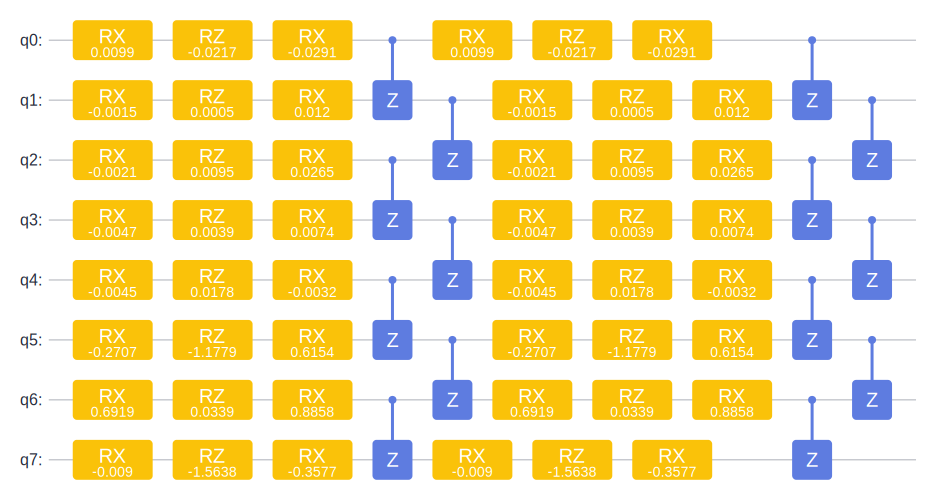

In [18]:
pr_ansatz = dict(zip(ansatz.params_name, Qnet.weight.asnumpy()))  # 获取线路参数
print('pr_ansatz = ', pr_ansatz)

ansatz_ = ansatz.apply_value(pr_ansatz)
U = ansatz_.matrix()
ansatz_.svg()

In [19]:
from mindquantum.core.gates import I, Z

def mat_m(qubit_num):
    M_0 = np.kron(I.matrix(), Z.matrix())
    M_1 = np.kron(Z.matrix(), I.matrix())
    for i in range(qubit_num - 2):
        M_0 = np.kron(M_0, I.matrix())
        M_1 = np.kron(M_1, I.matrix())

    return M_0 - M_1

M = mat_m(8)

In [15]:
X_train = [data[0] for data in train_loader]
y_train = [data[1] for data in train_loader]
# X_train = X_train[0]  # 一个batch, 即100个样本点
# y_train = y_train[0]
# print(len(X_train))
# print(y_train)

100
[0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1
 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0
 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0]


In [12]:
X_test = [data[0] for data in test_loader]
y_test = [data[1] for data in test_loader]
# X_test = X_test[0]  # 一个batch, 即100个样本点
# y_test = y_test[0]
# print(X_train)
# print(y_train)

In [21]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [13]:
predict_by_measure = []
predict_by_prob = []
predict_by_expectation = []
for i in range(2):
    X_test_ = X_test[i]  # 一个batch, 即100个样本点
    y_test_ = y_test[i]
    for sample in X_test_:
        pr_encoder = dict(zip(encoder.params_name, sample.tolist()))  # 获取线路参数
        # print('pr_encoder = ', pr_encoder)
    
        encoder_ = encoder.apply_value(pr_encoder)
        rho = encoder_.get_qs(backend='mqmatrix')

        tr = np.real(np.trace(rho @ rho))
        print("tr = {}".format(tr))
        # circuit_ = encoder_ + ansatz_
        # sim_ = Simulator('mqvector', circuit_.n_qubits)
        # sim_.apply_circuit(circuit_)
        # m1 = np.real(sim_.get_expectation(meas[0]))
        # m2 = np.real(sim_.get_expectation(meas[1]))
        # # print('m1 = ', m1)
        # # print('m2 = ', m2)
        # if m1 > m2:
        #     predict_by_expectation.append(0)
        # else:
        #     predict_by_expectation.append(1)
    
    #     m = np.real(np.trace(U.conj().T @ M @ U @ rho))
    #     if m > 0:
    #         predict_by_measure.append(0)
    #     else:
    #         predict_by_measure.append(1)
    
    #     p0 = logistic(m)
    #     p1 = 1 - p0
    #     if p0 > p1:
    #         predict_by_prob.append(0)
    #     else:
    #         predict_by_prob.append(1)


            
    # for j in range(len(y_test_)):
    #     if predict_by_measure[j + i*100] != y_test_[j]:
    #         print("the {}th sample prediction error".format(j + 1 + i*100))
    #         print('(measure) predict: ', predict_by_measure[j + i*100])
    #         print('actual: ', y_test_[j])
    #     if predict_by_prob[j + i*100] != y_test_[j]:
    #         print("the {}th sample prediction error".format(j + 1 + i*100))
    #         print('(prob) predict: ', predict_by_prob[j + i*100])
    #         print('actual: ', y_test_[j])
    #         print()

    # print('predict_by_expectation: ', predict_by_expectation)
    # print('actual y_train: ', y_test_)

print("ok")

tr1.0000000000000004
tr0.9999999999999998
tr1.0000000000000002
tr1.0000000000000004
tr1.0000000000000002
tr0.9999999999999998
tr1.0000000000000002
tr0.9999999999999999
tr1.0
tr1.0
tr0.9999999999999997
tr0.9999999999999998
tr0.9999999999999999
tr0.9999999999999998
tr0.9999999999999998
tr1.0
tr1.0
tr0.9999999999999998
tr1.0000000000000002
tr0.9999999999999999
tr0.9999999999999999
tr1.0
tr1.0
tr0.9999999999999999
tr0.9999999999999999
tr1.0
tr1.0
tr0.9999999999999998
tr1.0
tr1.0
tr0.9999999999999996
tr1.0
tr1.0
tr1.0
tr0.9999999999999998
tr1.0
tr1.0000000000000002
tr1.0
tr1.0
tr1.0
tr1.0000000000000002
tr1.0
tr1.0
tr1.0000000000000002
tr0.9999999999999998
tr0.9999999999999999
tr0.9999999999999999
tr0.9999999999999998
tr1.0
tr0.9999999999999998
tr1.0
tr1.0
tr0.9999999999999999
tr0.9999999999999998
tr1.0000000000000002
tr1.0000000000000004
tr1.0
tr1.0000000000000004
tr1.0000000000000002
tr1.0
tr1.0
tr1.0000000000000004
tr1.0
tr1.0000000000000002
tr0.9999999999999996
tr1.0
tr1.0
tr1.000000000